## Laboratorio 4

### Andre Marroquin Tarot- 22266

### Sergio Orellana- 221122

### Rodrigo Mansilla 22611

LINK GIT: https://github.com/mar22266/LABORATORIOS-IA.git


# Task 1

1. Explique con sus propias palabras, qué son los grafos computaciones y cuál es su importancia para el 
cálculo de gradientes en aplicaciones como backpropagation 

        R//


2. Detalle cuales son los componentes y pasos que conforman una red neuronal. Con esto en mente, ¿cómo 
mejoraría el perceptrón que hizo en el laboratorio pasado? 

        R//


3. Investigue y explique cómo se selecciona el valor K usando el método de la silueta para el algoritmo de K
Means. Explique las fórmulas (ecuaciones) que lo componen así como las asumpciones, si hay. 

        R//


4. Investigue sobre Principal Component Analysis (PCA) y responda respecto a algoritmos como K-Means: 
a. ¿Cómo podría ayudarle a mejorar la calidad de sus clusters cuando se usa K-Means?

        R//

# Task 2 y 2.1 - K-Means y Segmentación de Clientes de Banco

# 2.1.1 - K-Means

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

In [54]:
# Cargar el archivo CSV
df = pd.read_csv("bank_transactions.csv")

# ----------------------------
# Exploración de Datos
# ----------------------------

# Ver información general
df.info()

# Ver primeras filas del dataset
df.head()

# Verificar valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [55]:
# Balanceo del Dataset
# Verificar distribución de clientes por género para detectar desbalance
gender_counts = df['CustGender'].value_counts()
print("Distribución por Género:")
print(gender_counts)

# Verificar distribución de transacciones por ubicación para detectar posibles desbalances
location_counts = df['CustLocation'].value_counts()
print("Distribución por Ubicación (Top 10):")
print(location_counts.head(10))

Distribución por Género:
CustGender
M    765530
F    281936
T         1
Name: count, dtype: int64
Distribución por Ubicación (Top 10):
CustLocation
MUMBAI       103595
NEW DELHI     84928
BANGALORE     81555
GURGAON       73818
DELHI         71019
NOIDA         32784
CHENNAI       30009
PUNE          25851
HYDERABAD     23049
THANE         21505
Name: count, dtype: int64


#### El dataset presenta un desbalance en la variable CustGender, donde los hombres (1) son aproximadamente tres veces más que las mujeres (0), y los valores 2 y 3 parecen errores o categorías mal definidas. Sin embargo, este desbalance no afecta el análisis, ya que en clustering no se trabaja con clases predefinidas, sino con la identificación de patrones en los datos. Por ello, no es necesario balancearlo, ya que K-Means agrupará los clientes según sus similitudes sin depender de etiquetas de clase.

In [56]:
# Preprocesamiento de Datos
# Conversión de fecha de nacimiento en edad
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')
df['Age'] = 2025 - df['CustomerDOB'].dt.year  
df.drop(columns=['CustomerDOB'], inplace=True)  

# Codificación de variables categóricas
encoder = LabelEncoder()
# LOS LABELS SE TRATAN ASI  # M -> 1, F -> 0, U -> desconocido
df['CustGender'] = encoder.fit_transform(df['CustGender'].fillna('U')) 
df['CustLocation'] = encoder.fit_transform(df['CustLocation'].fillna('Unknown'))

# Rellenar valores nulos con la mediana
df['CustAccountBalance'].fillna(df['CustAccountBalance'].median(), inplace=True)

# Seleccionar solo variables numéricas para clustering
features = ['CustAccountBalance', 'TransactionAmount (INR)', 'Age']
data = df[features].dropna()

# Escalado de variables
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

C:\Users\andre\AppData\Local\Temp\ipykernel_41488\148061079.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')
C:\Users\andre\AppData\Local\Temp\ipykernel_41488\148061079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CustAccountBalance'].fillna(df['CustAccountBalance'].median(), inplace=True)


# Implementación de K-Means (Sin librerías)

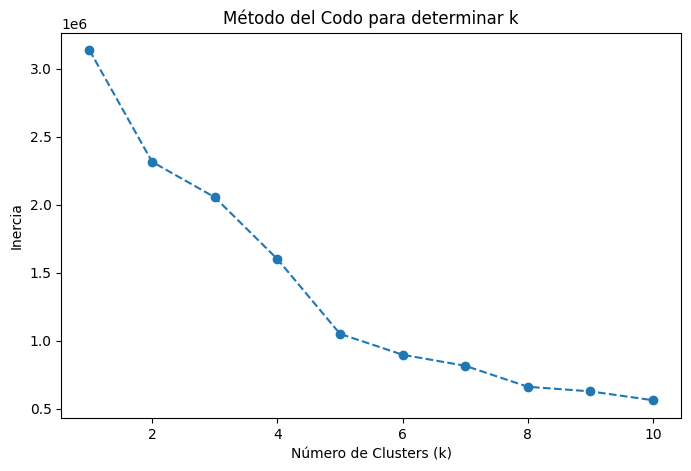

In [57]:

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def kmeans(data, k, max_iters=30):
    np.random.seed(42)
    centroids = data[np.random.choice(len(data), k, replace=False)]
    
    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[cluster_assignments == i].mean(axis=0) if np.any(cluster_assignments == i) else centroids[i] for i in range(k)])
        
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    
    return cluster_assignments, centroids

# Determinar el mejor número de clusters con el método del codo
inertia = []
k_values = range(1, 11)
for k in k_values:
    labels, centroids = kmeans(data_scaled, k)
    inertia.append(np.sum(np.min(np.linalg.norm(data_scaled[:, np.newaxis] - centroids, axis=2), axis=1)**2))

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar k')
plt.show()


# Métrica de Desempeño
### Se utilizará la métrica de coeficiente de silueta para evaluar el desempeño del clustering.
### Justificación: El coeficiente de silueta mide qué tan bien separado está cada cluster y qué tan compacto es.

In [58]:
from sklearn.metrics import silhouette_score
# Seleccionar el mejor número de clusters basado en el método del codo
best_k = 4  

# Aplicar K-Means con el mejor k
labels, centroids = kmeans(data_scaled, best_k)
data['Cluster'] = labels


In [59]:
from sklearn.utils import resample

sample_size = 100000  # Usamos cien mil de muestra ya que son un millon de datos y no se puede hacer el calculo con todos debido a recursos de la maquina
data_sample, labels_sample = resample(data_scaled, data['Cluster'], n_samples=sample_size, random_state=42)

silhouette_avg = silhouette_score(data_sample, labels_sample)
print(f"Métrica de Desempeño (Coeficiente de Silueta) para {best_k} clusters: {silhouette_avg}")


Métrica de Desempeño (Coeficiente de Silueta) para 4 clusters: 0.7791020713169333


# Features seleccionados
## Justificación: PCA reduce la dimensionalidad del dataset y nos permite visualizar los clusters en dos dimensiones principales sin pérdida significativa de información

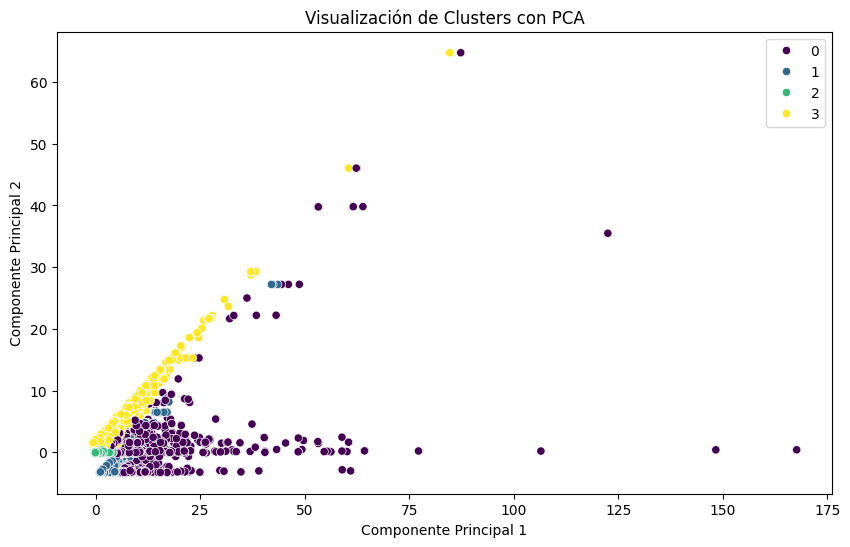

In [60]:
# Visualización de Clusters

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters con PCA')
plt.legend()
plt.show()


# Implementación de K-Means (Con librerías)

In [61]:
from sklearn.cluster import KMeans

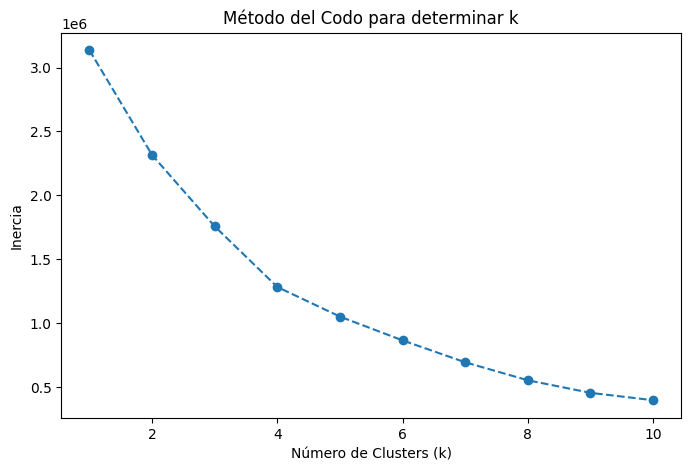

In [62]:
# Determinar el mejor número de clusters con el método del codo
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10, max_iter=300)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar k')
plt.show()


In [63]:
# Seleccionar el mejor número de clusters basado en el método del codo
best_k = 4 

# Entrenar modelo K-Means con el mejor k
kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10, max_iter=300)
data['Cluster'] = kmeans.fit_predict(data_scaled)

In [64]:
from sklearn.utils import resample
from sklearn.metrics import silhouette_score

# Definir el tamaño de la muestra
sample_size = min(100000, len(data_scaled))  # Asegurar que no exceda el total de datos disponibles

# Tomar una muestra aleatoria del dataset
data_sample, labels_sample = resample(data_scaled, data['Cluster'], n_samples=sample_size, random_state=42)

# Calcular el coeficiente de silueta en la muestra
silhouette_avg = silhouette_score(data_sample, labels_sample)
print(f"Métrica de Desempeño (Coeficiente de Silueta) para {best_k} clusters: {silhouette_avg}")


Métrica de Desempeño (Coeficiente de Silueta) para 4 clusters: 0.841667407361284


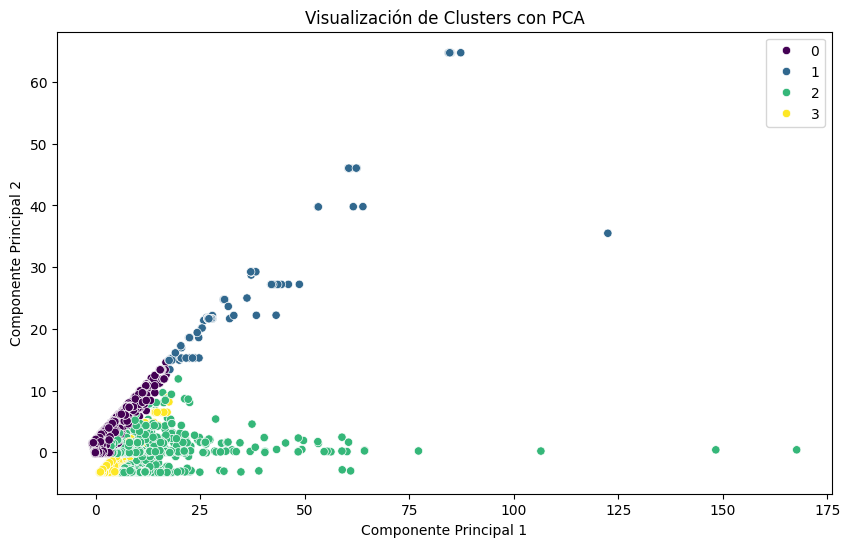

In [65]:
# Visualización de Clusters

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters con PCA')
plt.legend()
plt.show()

# Conlusion

### El modelo de K-Means con librerías es mejor, ya que obtuvo un coeficiente de silueta de 0.8417, mientras que la implementación sin librerías obtuvo 0.7791. Un coeficiente de silueta más alto indica que los clusters están mejor separados y son más compactos internamente. La diferencia se debe a que sklearn.KMeans utiliza optimizaciones avanzadas en Cython y técnicas como k-means++ para una mejor inicialización de centroides, lo que mejora la calidad del clustering y reduce la variabilidad en los resultados. 

# Task 2.2 - Mixture Modelos y Segmentación de Clientes de Banco Task 2.2.1 - Mixture Models 